In [152]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

import sys

sys.path.append('..')
from Dynearthsol import Dynearthsol

In [153]:
# Constants
PI = np.pi
EPS = 0.0001
N = 500  # Replace with the appropriate value for N

# Hydraulic parameters
perm = 1.02e-12  # Permeability (m^2)
rho_f = 1000  # Density of fluid (kg/m^3)
eta_f = 1.002e-3  # Dynamic viscosity of fluid (Pa.s)
# grav = 10  # Gravitational acceleration (m/s^2)
grav = 9.81  # Gravitational acceleration (m/s^2)
gamma_w = grav * rho_f  # Unit weight of water (N/m^3)
cond = perm * gamma_w / eta_f  # Hydraulic conductivity (m/s)
phi = 0.3  # Porosity
beta_w = 1 / 2.17e9  # Compressibility of water (1/Pa)

# Mechanic parameters
K_bulk = 1e7  # Bulk modulus (Pa)
mu = 1e7  # Shear modulus (Pa)
K_s = 1e38  # Bulk modulus of solid grain (Pa)
E = (9 * K_bulk * mu) / (3 * K_bulk + mu)  # Young's modulus
nu = (3 * K_bulk - 2 * mu) / (2 * (3 * K_bulk + mu))  # Poisson's ratio based on K and G

alpha_c = 1 - K_bulk / K_s  # Biot coefficient

dd = 5.0  # Width
# TWO_F = 1e6  # Applied stress
F = 1e5

AM11 = E * (1 - nu) / (1 - nu - 2 * nu * nu) # E*(1-PNU)/(1-PNU-2*PNU*PNU)
AM33 = AM11
AM13 = E * nu / (1 - nu - 2 * nu * nu) # E*PNU/(1-PNU-2*PNU*PNU)

# Bulk modulus of the mixture
# BM = 1 / (phi * beta_w)  # Simplified form because K_s is very large
BM = 1/(4.5E-10*phi)
BMU = AM11 + BM

CV = (perm * BM * AM11) / (eta_f * BMU)
A11 = (AM33 - 2 * AM13 + AM11) / (AM11 - AM13) # (AM33-2*AM13+AM11)/(AM11-AM13)
A1 = A11 + (AM11 * AM33 - AM13 * AM13) / (BM * (AM11 - AM13)) # A11+(AM11*AM33-AM13*AM13)/(BM*(AM11-AM13))
A2 = (AM11 - AM13) / AM11

ETA = A1 / A2

# Initialize array for zeros
zeros = np.zeros(N)

print("hcond", cond)
print("Young's mod (MPa)", E/1e6)
print("Poisson's ratio", nu)
print("Cv", CV)
print("AM11", 1/AM11)
print("AM13", 1/AM13)
print("A1", A1)
print("A2", A2)
print("M11", AM11)
print("M13", AM13)

# MADEL'S ROOT 
for i in range(1, N + 1):
    e1 = (i - 1) * PI + PI / 4.0
    e2 = e1 + PI / 2.0 - EPS

    for j in range(500):
        y1 = np.tan(e1) - ETA * e1
        y2 = np.tan(e2) - ETA * e2
        em = (e1 + e2) / 2.0
        ym = np.tan(em) - ETA * em

        if ym * y1 > 0:
            e1 = em
        else:
            e2 = em

        if abs(y2) < EPS:
            em = e2

    zeros[i - 1] = em
    # print(i, zeros[i - 1])

# Displacement calculations
UX1 = 2 * F * (AM13 / (AM11 * AM33 - AM13 * AM13))
UX2 = 4 * F * ((BM + AM13) / (A1 * BM * (AM11 - AM13)))
UX3 = 2 * F / (A2 * AM11)
UZ1 = UX1 * (1 + 2 * (A2 / A1 - 1))

# Initialize variables
NN = 400  # Replace with appropriate value for NN
time = np.linspace(0, 2000, NN)  # Time array
# Time array using logspace for log-scale plot, expanding up to 1e5
# time = np.logspace(np.log10(1), np.log10(1e5), NN)
PP = np.zeros(NN)
XD = np.zeros(NN)
ZD = np.zeros(NN)
mon_p = 0.0

# Calculate pore pressure, X displacement, Z displacement
for j in range(NN):
    S = 0.0
    C = 0.0
    SX = 0.0
    CX = 0.0
    EX = 0.0
    varpp = 0.0
    varxd = 0.0
    varxd2 = 0.0
    varzd = 0.0

    for i in range(500):
        S = np.sin(zeros[i]) 
        SX = np.sin(dd * zeros[i] / dd) 
        C = np.cos(zeros[i])
        CX = np.cos(mon_p * zeros[i] / dd) 
        EX = np.exp(-zeros[i] * zeros[i] * CV * time[j] / (dd * dd)) 
        varpp += S * (CX - C) * EX / (zeros[i] - S * C)  
        varzd += 2 * (A2 / A1 - 1) * (S * C) / (zeros[i] - S * C) * EX
        varxd += (S * C) / (zeros[i] - S * C) * EX
        varxd2 += C / (zeros[i]- S * C) * SX * EX

    PP[j] = 2 * F * varpp / A1 
    ZD[j] = -2 * F * (AM11 / (AM11 * AM11 - AM13 * AM13)) * (1 + varzd) * 2
    XD[j] = 2 * F * (AM13 / (AM11 * AM33 - AM13 * AM13))
    XD[j] = (XD[j] + 4 * F * (BM + AM13) / (A1 * BM * (AM11 - AM13)) * varxd) * 2
    XD[j] += 2 * F / (A2 * AM11) * varxd2

# # Plotting (PT refers to pseudo-transient iterations)
# plt.figure(figsize=(12, 8))


# # Plot analytical solution
# plt.plot(time, PP/1e5, label=f'Analytical solution', color='r', linestyle='-', linewidth=2)
# # plt.plot(time_f, PP_f / 1e5, label='Analytical solution', color='b', linestyle='-', linewidth=2)

# # Customize plot aesthetics
# plt.xscale('log')
# plt.xlabel('Time (sec)', fontsize=16)
# plt.ylabel('Pore Pressure (Bar)', fontsize=16)
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)

# # Add a thicker box by adjusting the linewidth for all spines
# plt.gca().spines['top'].set_linewidth(2.5)
# plt.gca().spines['right'].set_linewidth(2.5)
# plt.gca().spines['left'].set_linewidth(2.5)
# plt.gca().spines['bottom'].set_linewidth(2.5)

# # Grid, legend, and layout improvements
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.legend(fontsize=14)
# plt.tight_layout()

# # Show plot
# plt.show()

hcond 9.98622754491018e-06
Young's mod (MPa) 22.5
Poisson's ratio 0.125
Cv 0.023677909594756557
AM11 4.285714285714286e-08
AM13 3e-07
A1 2.0036
A2 0.8571428571428572
M11 23333333.333333332
M13 3333333.3333333335


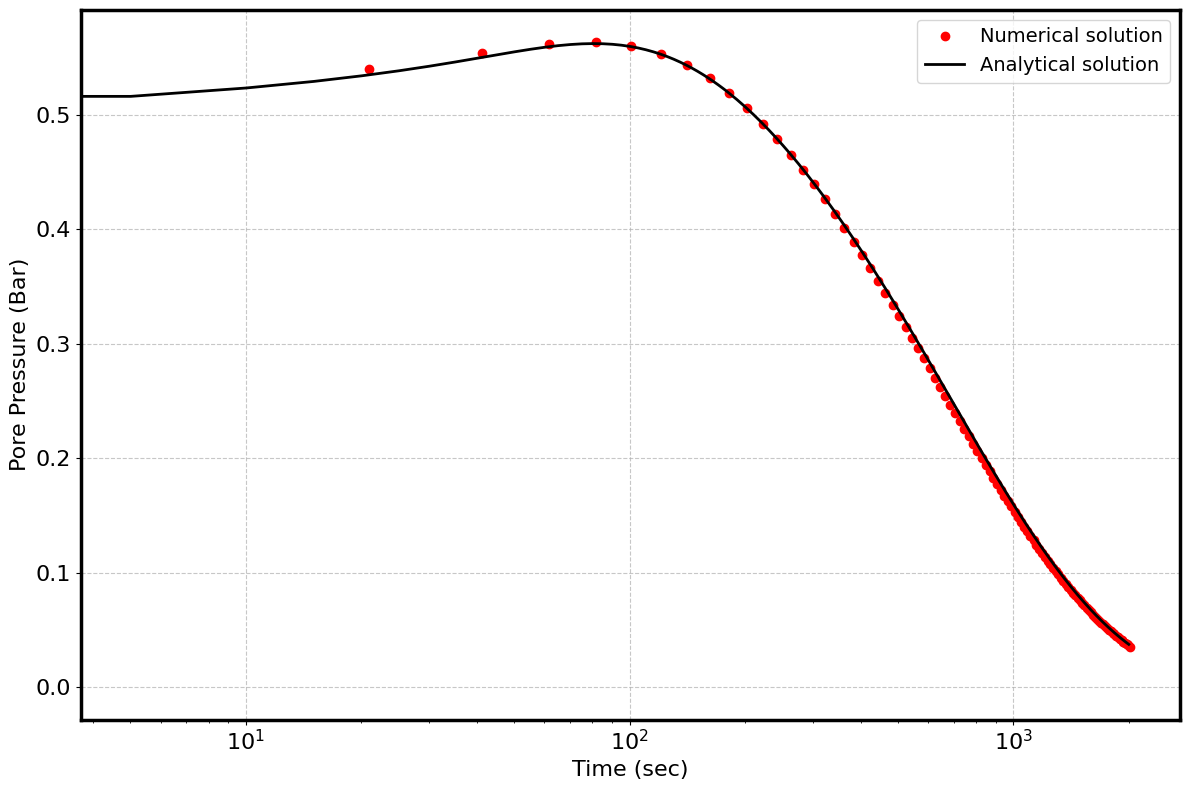

In [154]:
# Constants
ATMOSPHERIC_PRESSURE = 0.0  # Atmospheric pressure in appropriate units
GRAVITY = 10  # Acceleration due to gravity (m/s^2)
FLUID_DENSITY = 1000  # Fluid density (kg/m^3)
GAMMA_W = GRAVITY * FLUID_DENSITY  # Specific weight of water (N/m^3)

# Model names
MODEL_NAMES = [
    "mandel"
]

# Function to read time steps and times from the info file
def read_time_steps(filename):
    data = np.loadtxt(filename, usecols=(0, 2))
    time_steps = data[:, 0].astype(int)
    times = data[:, 1]
    return time_steps, times

# Function to perform numerical calculations for each time step
def numerical(num_steps, model_name):
    des = Dynearthsol(model_name)
    pore_pressures = np.zeros(num_steps, dtype=float)
    for time_step in range(num_steps):
        pore_pressure = des.read_field(time_step, 'pore pressure')
        coordinates = des.read_field(time_step, 'coordinate')
        pore_pressures[time_step] = pore_pressure[0] - ATMOSPHERIC_PRESSURE + GAMMA_W * coordinates[0, 1]
        # print(coordinates[0, :])
    return pore_pressures

# Read time steps and numerical times from the info file of one of the models
time_steps, times = read_time_steps(MODEL_NAMES[0] + '.info')
num_steps = len(time_steps)


# Run numerical calculations for all models
pore_pressures = [numerical(num_steps, model_name) for model_name in MODEL_NAMES]

# Plotting (PT refers to pseudo-transient iterations)
plt.figure(figsize=(12, 8))

# Plot numerical solution
plt.plot(times, pore_pressures[0] * 1e-5, 'o', color='red', markersize=6, linewidth=2, label=f'Numerical solution',)
plt.plot(time, PP/1e5, label=f'Analytical solution', color='k', linestyle='-', linewidth=2)

# Plot analytical solution
# plt.plot(time_points, P_ex_time, label=f'Analytical solution at depth = {H} m', color='k', linestyle='-', linewidth=2)

# Customize plot aesthetics
plt.xscale('log')
plt.xlabel('Time (sec)', fontsize=16)
plt.ylabel('Pore Pressure (Bar)', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Add a thicker box by adjusting the linewidth for all spines
plt.gca().spines['top'].set_linewidth(2.5)
plt.gca().spines['right'].set_linewidth(2.5)
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)

# Grid, legend, and layout improvements
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=14)
plt.tight_layout()

# Show plot
plt.show()